In [115]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 设置风格
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)

summary_df = pd.read_csv("data/summary_distributed.csv")
details_df = pd.read_csv("data/details_distributed.csv")
summary_df = summary_df[summary_df["concurrency"] < 40]
details_df = details_df[details_df["concurrency"] < 40]

summary_df["architecture"] = summary_df["architecture"].str.lower()
summary_df["fn_type"] = summary_df["fn_type"].str.lower()
details_df["architecture"] = details_df["architecture"].str.lower()
details_df["fn_type"] = details_df["fn_type"].str.lower()
summary_df["fn_type"] = summary_df["fn_type"].str.lower().replace("data_local", "data_locality")
details_df["fn_type"] = details_df["fn_type"].str.lower().replace("data_local", "data_locality")
deadline_map = summary_df[(summary_df["concurrency"] >= 5)].groupby("fn_type")["p95"].mean().to_dict()

details_df["deadline"] = details_df["fn_type"].map(deadline_map)
details_df["miss"] = details_df["response_time"] > details_df["deadline"]

miss_rate = details_df.groupby(["architecture", "fn_type", "concurrency"])["miss"].mean().reset_index()
miss_rate["miss_rate_percent"] = miss_rate["miss"] * 100

merged = pd.merge(summary_df, miss_rate, on=["architecture", "fn_type", "concurrency"])

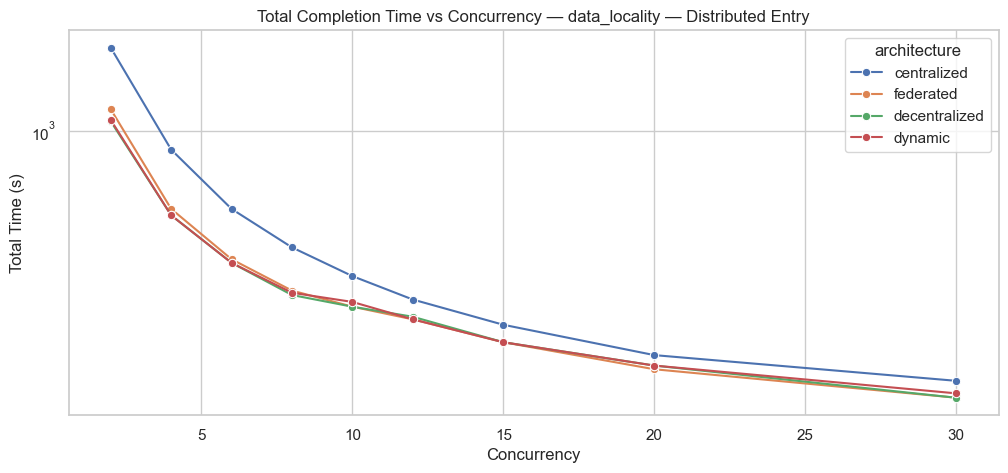

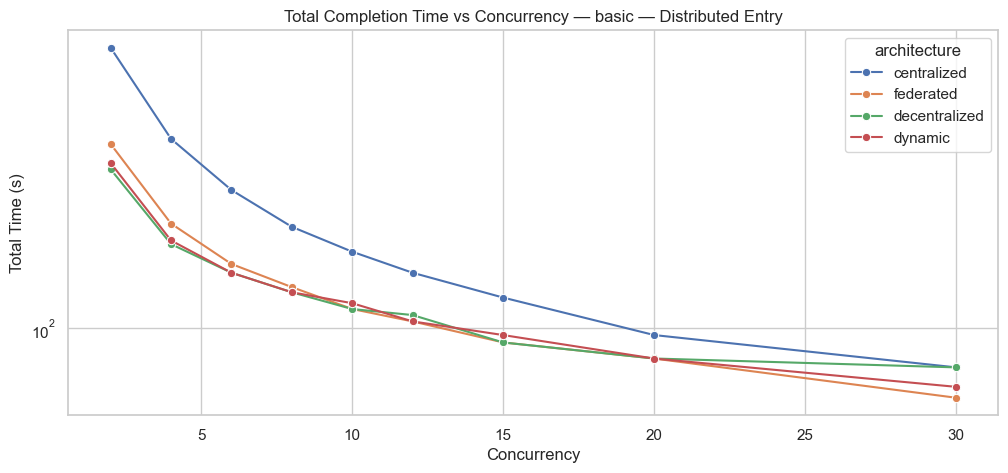

In [116]:
for fn in merged["fn_type"].unique():
    data = merged[merged["fn_type"] == fn]
    plt.figure()
    sns.lineplot(data=data, x="concurrency", y="total_time", hue="architecture", marker="o")
    plt.title(f"Total Completion Time vs Concurrency — {fn} — Distributed Entry")
    plt.ylabel("Total Time (s)")
    plt.xlabel("Concurrency")
    plt.yscale("log")
    plt.grid(True)
    plt.show()



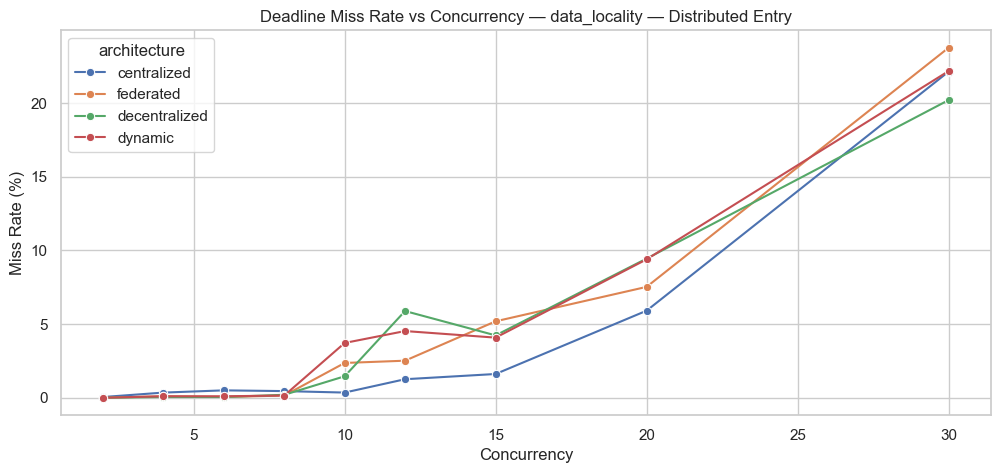

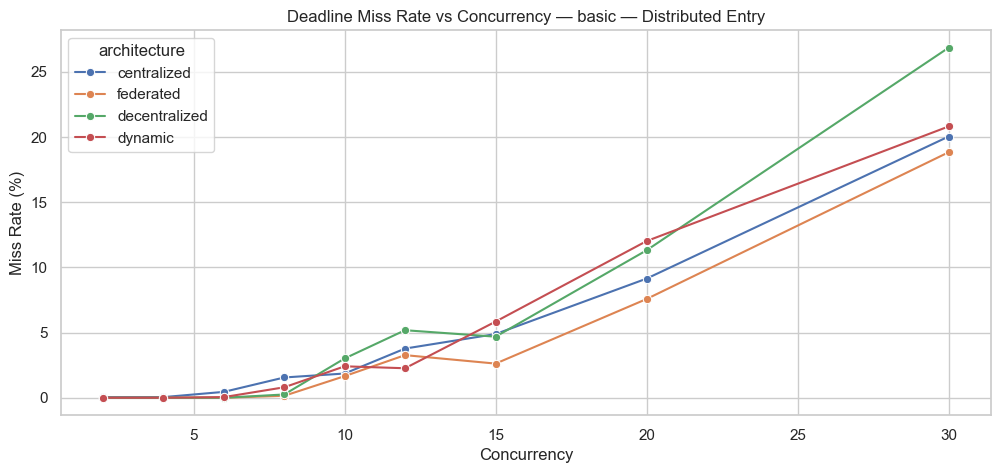

In [117]:
for fn in merged["fn_type"].unique():
    data = merged[merged["fn_type"] == fn]
    plt.figure()
    sns.lineplot(data=data, x="concurrency", y="miss_rate_percent", hue="architecture", marker="o")
    plt.title(f"Deadline Miss Rate vs Concurrency — {fn} — Distributed Entry")
    plt.ylabel("Miss Rate (%)")
    plt.xlabel("Concurrency")
    plt.grid(True)
    plt.show()


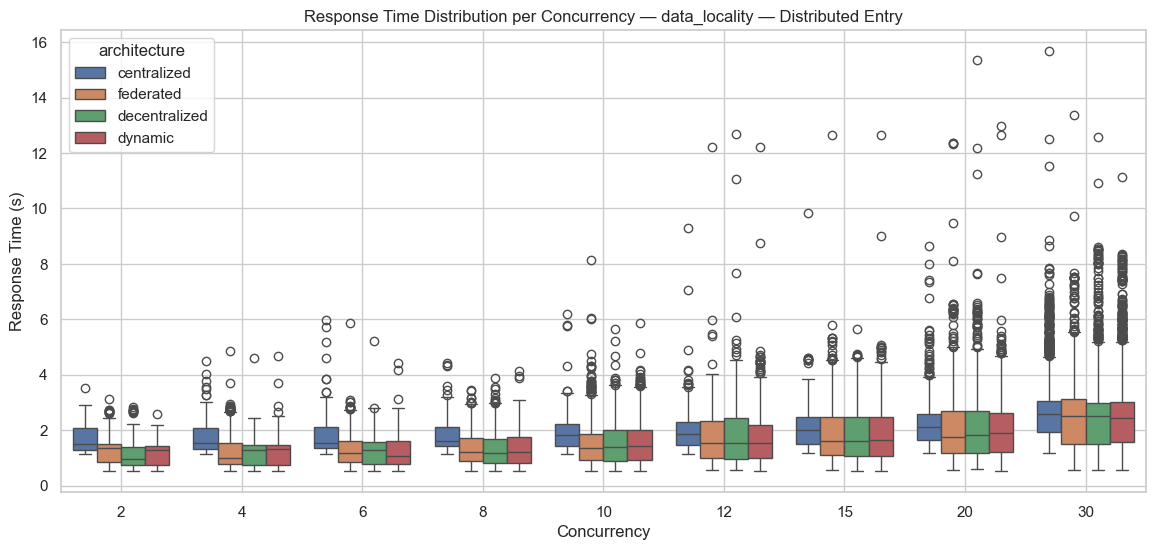

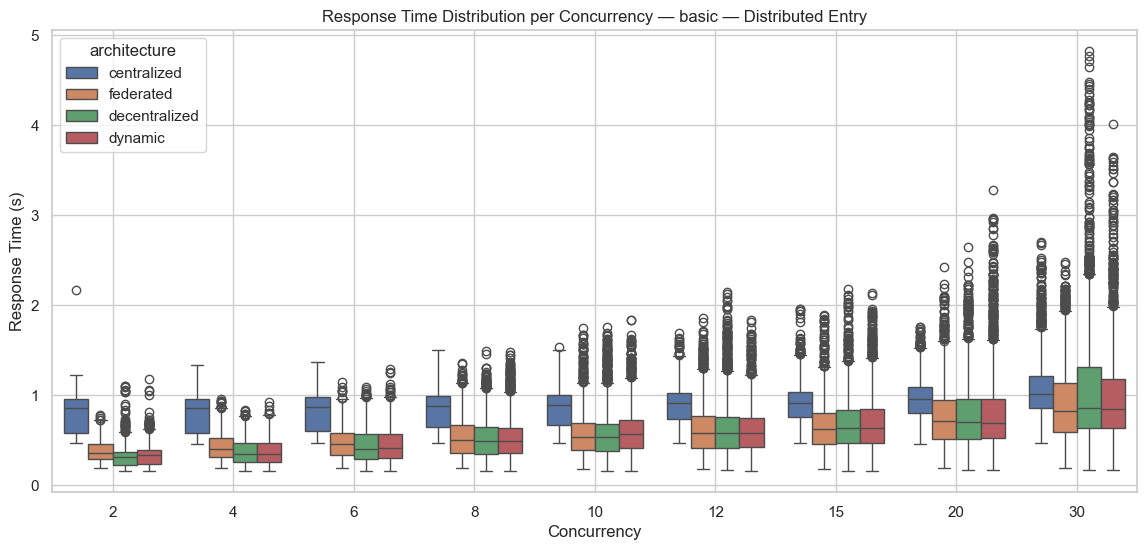

In [118]:
for fn in details_df["fn_type"].unique():
    plt.figure(figsize=(14,6))
    sns.boxplot(data=details_df[details_df["fn_type"] == fn],
                x="concurrency", y="response_time", hue="architecture")
    plt.title(f"Response Time Distribution per Concurrency — {fn} — Distributed Entry")
    plt.ylabel("Response Time (s)")
    plt.xlabel("Concurrency")
    plt.grid(True)
    plt.show()


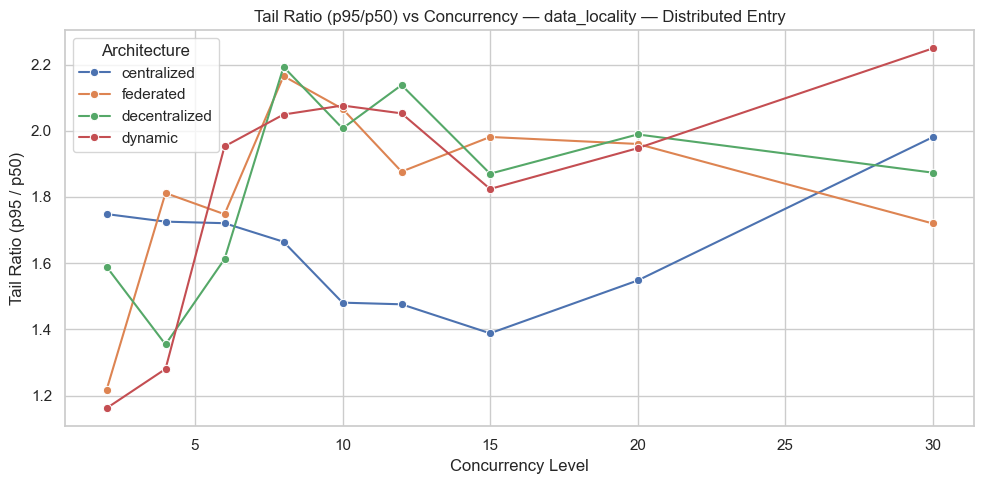

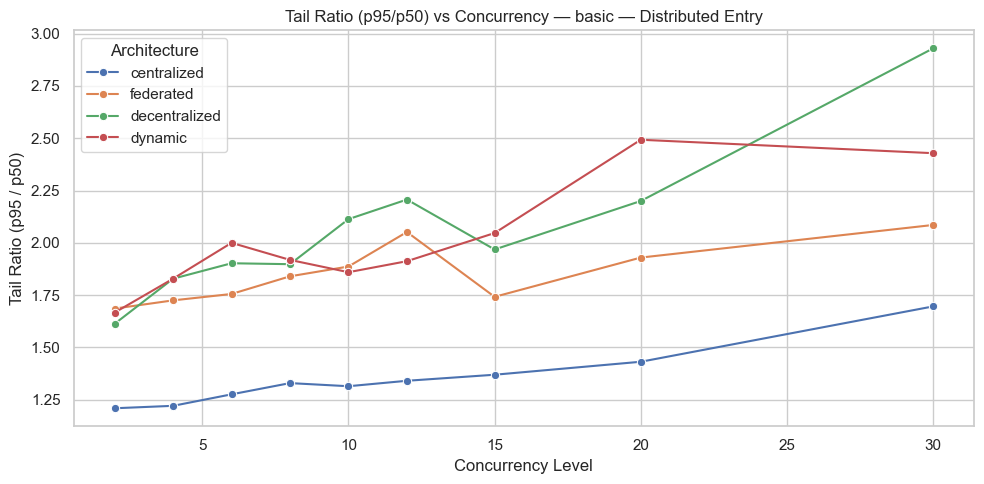

In [119]:

for fn_type in summary_df["fn_type"].unique():
    sub_df = summary_df[summary_df["fn_type"] == fn_type].copy()
    sub_df["tail_ratio"] = sub_df["p95"] / sub_df["p50"]

    plt.figure(figsize=(10, 5))
    sns.lineplot(data=sub_df, x="concurrency", y="tail_ratio", hue="architecture", marker="o")
    plt.title(f"Tail Ratio (p95/p50) vs Concurrency — {fn_type} — Distributed Entry")
    plt.ylabel("Tail Ratio (p95 / p50)")
    plt.xlabel("Concurrency Level")
    plt.grid(True)
    plt.legend(title="Architecture")
    plt.tight_layout()
    plt.show()

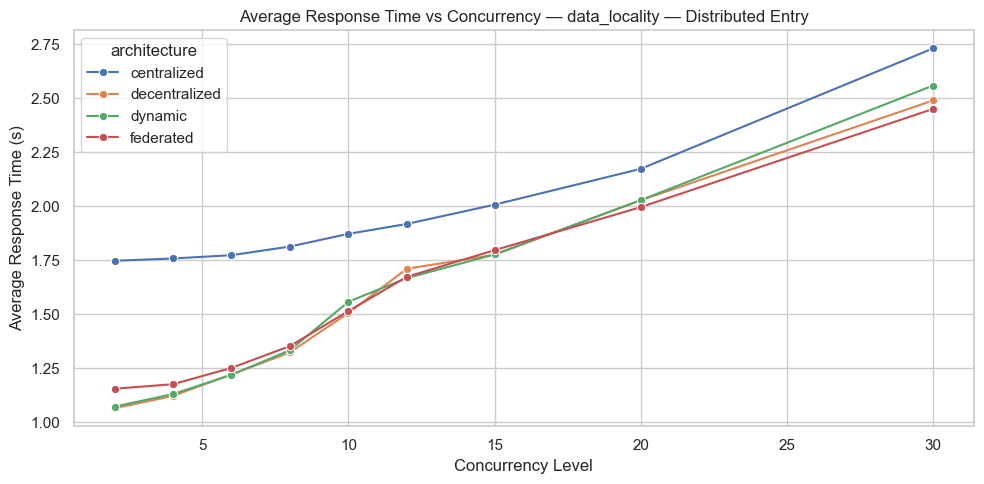

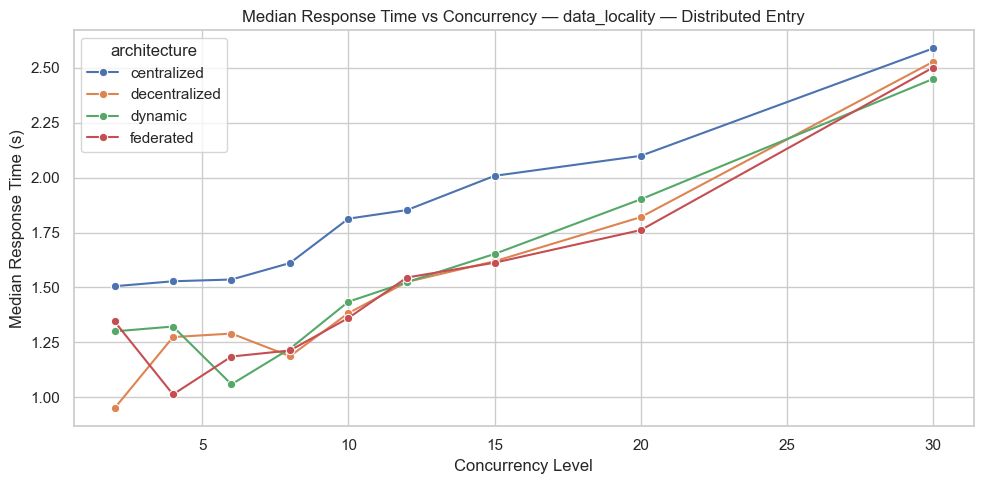

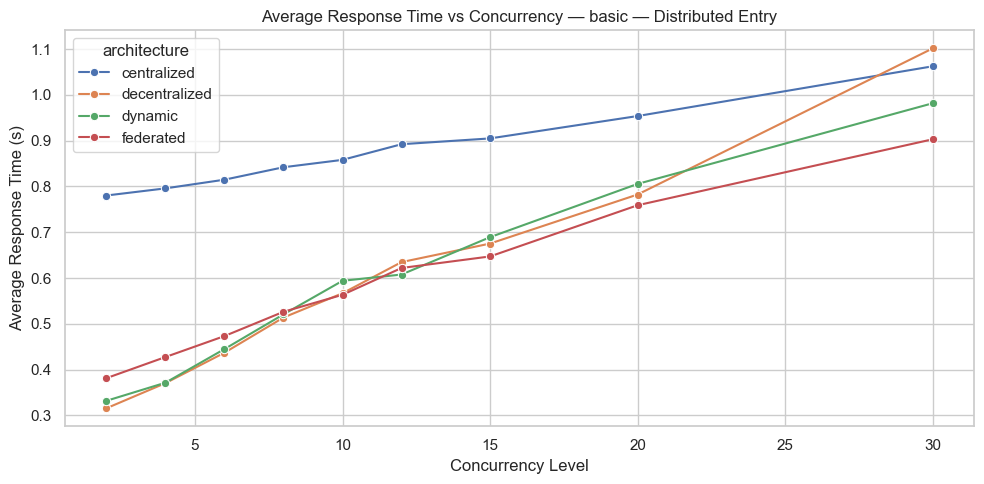

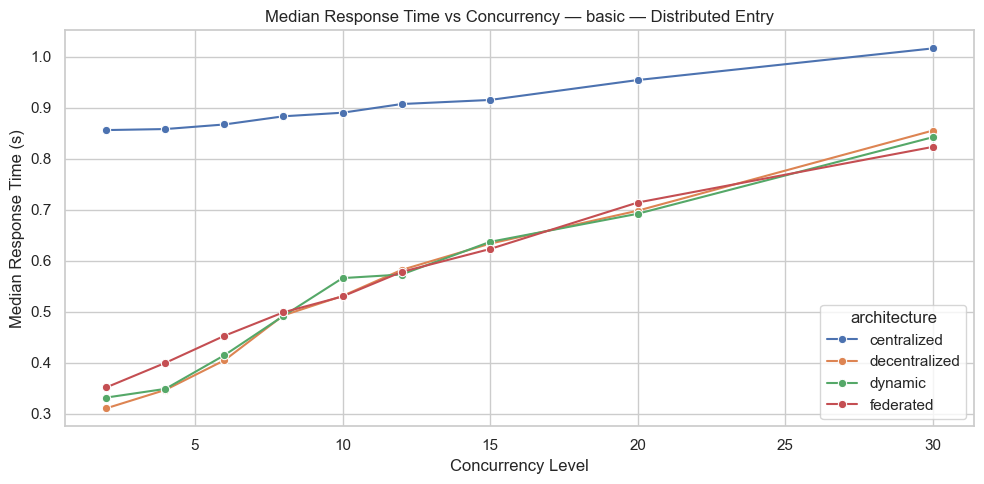

In [120]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 读取数据
# details_df = pd.read_csv("data/details_distributed.csv")
# details_df["response_time"] = details_df["response_time"].astype(float)
# details_df = details_df[details_df["concurrency"] < 40]

# 分任务类型处理
for fn in details_df["fn_type"].unique():
    sub_df = details_df[details_df["fn_type"] == fn]

    # 计算每个架构和并发下的平均 & 中位数
    agg_stats = sub_df.groupby(["architecture", "concurrency"])["response_time"].agg(["mean", "median"]).reset_index()

    # 平均响应时间图
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=agg_stats, x="concurrency", y="mean", hue="architecture", marker="o")
    plt.title(f"Average Response Time vs Concurrency — {fn} — Distributed Entry")
    plt.ylabel("Average Response Time (s)")
    plt.xlabel("Concurrency Level")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 中位数响应时间图
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=agg_stats, x="concurrency", y="median", hue="architecture", marker="o")
    plt.title(f"Median Response Time vs Concurrency — {fn} — Distributed Entry")
    plt.ylabel("Median Response Time (s)")
    plt.xlabel("Concurrency Level")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [121]:
from prometheus_api_client import PrometheusConnect
import pandas as pd
from datetime import datetime, timedelta

# 所有节点的 Prometheus 地址
PROM_HOSTS = {
    "yl-01": "http://yl-01.lab.uvalight.net:31119",
    "yl-02": "http://yl-02.lab.uvalight.net:31119",
    "yl-03": "http://yl-03.lab.uvalight.net:31119",
    "yl-04": "http://yl-04.lab.uvalight.net:31119",  # 包含 yl-04 和 yl-05
    "yl-06": "http://yl-06.lab.uvalight.net:31119"
}

# 查询时间范围：当前时间前1分钟
end_time = datetime.utcnow()
start_time = end_time - timedelta(minutes=1)

# 查询语句
cpu_query = '100 - (avg by (instance) (rate(node_cpu_seconds_total{mode="idle"}[1m])) * 100)'
mem_query = '(node_memory_MemTotal_bytes - node_memory_MemAvailable_bytes) / 1024 / 1024'

# 存储结果
records = []

for node, url in PROM_HOSTS.items():
    prom = PrometheusConnect(url=url, disable_ssl=True)

    try:
        # CPU usage
        cpu_data = prom.custom_query(query=cpu_query)
        for result in cpu_data:
            instance = result["metric"].get("instance", "")
            value = float(result["value"][1])
            records.append({
                "host": node,
                "instance": instance,
                "metric": "cpu_usage_percent",
                "value": round(value, 2)
            })

        # Memory usage
        mem_data = prom.custom_query(query=mem_query)
        for result in mem_data:
            instance = result["metric"].get("instance", "")
            value = float(result["value"][1])
            records.append({
                "host": node,
                "instance": instance,
                "metric": "memory_usage_MB",
                "value": round(value, 2)
            })

    except Exception as e:
        print(f"[{node}] ❌ Query failed: {e}")

# 转为 DataFrame 展示
df = pd.DataFrame(records)
# print(df.pivot(index=["host", "instance"], columns="metric", values="value").reset_index())


In [122]:
df["instance"] = df["instance"].str.extract(r"(yl-\d+)")


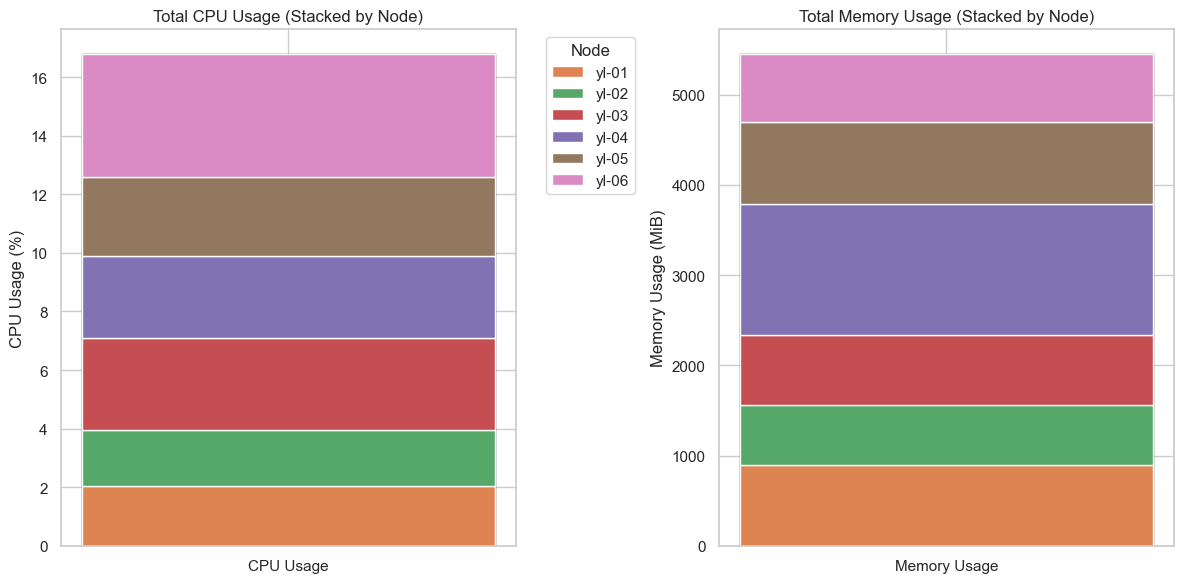

In [123]:

df_pivot = df.pivot_table(index="instance", columns="metric", values="value", aggfunc="sum").fillna(0).reset_index()

# 画堆叠柱状图（和你图一致，每图一个柱子）
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 图 1: CPU Usage
axes[0].bar("CPU Usage", df_pivot["cpu_usage_percent"].sum(), color=None, edgecolor="black")
bottom = 0
for _, row in df_pivot.iterrows():
    axes[0].bar("CPU Usage", row["cpu_usage_percent"], bottom=bottom, label=row["instance"])
    bottom += row["cpu_usage_percent"]
axes[0].set_ylabel("CPU Usage (%)")
axes[0].set_title("Total CPU Usage (Stacked by Node)")
axes[0].legend(title="Node", bbox_to_anchor=(1.05, 1), loc="upper left")

# 图 2: Memory Usage
axes[1].bar("Memory Usage", df_pivot["memory_usage_MB"].sum(), color=None, edgecolor="black")
bottom = 0
for _, row in df_pivot.iterrows():
    axes[1].bar("Memory Usage", row["memory_usage_MB"], bottom=bottom, label=row["instance"])
    bottom += row["memory_usage_MB"]
axes[1].set_ylabel("Memory Usage (MiB)")
axes[1].set_title("Total Memory Usage (Stacked by Node)")

plt.tight_layout()
plt.show()

In [124]:
df

,host,instance,metric,value
0,yl-01,yl-01,cpu_usage_percent,2.04
1,yl-01,yl-01,memory_usage_MB,891.73
2,yl-02,yl-02,cpu_usage_percent,1.93
3,yl-02,yl-02,memory_usage_MB,671.46
4,yl-03,yl-03,cpu_usage_percent,3.14
5,yl-03,yl-03,memory_usage_MB,767.34
6,yl-04,yl-05,cpu_usage_percent,2.68
7,yl-04,yl-04,cpu_usage_percent,2.80
8,yl-04,yl-05,memory_usage_MB,911.14
9,yl-04,yl-04,memory_usage_MB,1451.71
